# Preliminary Analysis & Baseline Models

### CMSE 492 — Building Electricity Usage & Building Age

**Author: Badri Aiman Khan Badrul Zeman**

**Date: Fall 2025**

This notebook performs the initial analysis for the project investigating how building characteristics especially building age affect electricity usage.

The goals of this notebook are to load raw building electricity and metadata files, clean and merge datasets, explore initial patterns, test simple baseline models predicting electricity usage, export a cleaned dataset for future notebooks.

### Load and process data

In [37]:
import pandas as pd
from pathlib import Path

electricity = pd.read_csv('electricity_cleaned.csv')
metadata = pd.read_csv('metadata.csv')

In [83]:
# electricity has: timestamp + many building columns
id_col = 'timestamp'
value_name = 'usage_kwh'

# Melt to long format: one row per (timestamp, building_id)
elec_long = electricity.melt(
    id_vars=[id_col],
    var_name='building_id',
    value_name=value_name
)

# Make sure usage is numeric (coerce non-numeric to NaN)
elec_long[value_name] = pd.to_numeric(elec_long[value_name], errors='coerce')

print ( elec_long.head())
print ("The datasets shape is: ",elec_long.shape)
print ( elec_long.describe())


             timestamp               building_id  usage_kwh
0  2016-01-01 00:00:00  Panther_parking_Lorriane        NaN
1  2016-01-01 01:00:00  Panther_parking_Lorriane        NaN
2  2016-01-01 02:00:00  Panther_parking_Lorriane        NaN
3  2016-01-01 03:00:00  Panther_parking_Lorriane        NaN
4  2016-01-01 04:00:00  Panther_parking_Lorriane        NaN
The datasets shape is:  (27684432, 3)
          usage_kwh
count  2.521258e+07
mean   1.449146e+02
std    2.688494e+02
min    1.000000e-04
25%    1.937500e+01
50%    5.957000e+01
75%    1.568667e+02
max    2.212280e+05


**Some information we know about the size of the dataset is given above and from the head we can see the headers consists of timestamps, building id and electricity usage(usage_kwh)**

In [75]:
# Mean usage per building (you could also use .sum() or .median())
usage_summary = (
    elec_long
    .dropna(subset=[value_name])
    .groupby('building_id', as_index=False)[value_name]
    .mean()
    .rename(columns={value_name: 'avg_usage_kwh'})
)

usage_summary.head()


,building_id,avg_usage_kwh
0,Bear_assembly_Angel,494.336396
1,Bear_assembly_Beatrice,42.962056
2,Bear_assembly_Danial,160.655729
3,Bear_assembly_Diana,0.856884
4,Bear_assembly_Genia,261.089054


### Data Cleaning Procedures

**i. *Handle missing values***

In [77]:
# Check missing values in electricity dataset
print("Missing values in electricity_cleaned.csv:")
elec_long.isna().sum()

Missing values in electricity_cleaned.csv:


timestamp            0
building_id          0
usage_kwh      2471853
dtype: int64

In [32]:
# Check missing values in metadata dataset
print("Missing values in metadata.csv:")
metadata.isna().sum()

Missing values in metadata.csv:


building_id                 0
site_id                     0
building_id_kaggle        187
site_id_kaggle             37
primaryspaceusage          21
sub_primaryspaceusage      21
sqm                         0
sqft                        0
lat                       237
lng                       237
timezone                    0
electricity                58
hotwater                 1451
chilledwater             1081
steam                    1266
water                    1490
irrigation               1599
solar                    1631
gas                      1459
industry                 1057
subindustry              1057
heatingtype              1421
yearbuilt                 819
date_opened              1615
numberoffloors           1195
occupants                1406
energystarscore          1473
eui                      1337
site_eui                 1473
source_eui               1473
leed_level               1620
rating                   1452
dtype: int64

**ii. *Handling missing Values based on HOML***

In [39]:
# --- Drop missing electricity usage (critical target variable) ---
metadata_clean = metadata.dropna(subset=['electricity']).copy()

# --- Drop missing building types (only 21 rows missing, safe to remove) ---
metadata_clean = metadata_clean.dropna(subset=['primaryspaceusage', 'sub_primaryspaceusage'])

# --- Combine yearbuilt and date_opened (chapter 3: use related features) ---
metadata_clean['date_opened'] = pd.to_datetime(metadata_clean['date_opened'], errors='coerce')

# Create new column for imputed year built
metadata_clean['yearbuilt_filled'] = metadata_clean['yearbuilt']

# Use date_opened year where yearbuilt is missing
metadata_clean['yearbuilt_filled'] = metadata_clean['yearbuilt_filled'].fillna(
    metadata_clean['date_opened'].dt.year
)

# Drop rows where age is still missing
metadata_clean = metadata_clean.dropna(subset=['yearbuilt_filled'])

# Reset index for cleanliness
metadata_clean = metadata_clean.reset_index(drop=True)


In [63]:
electricity.columns


Index(['timestamp', 'Panther_parking_Lorriane', 'Panther_lodging_Cora',
       'Panther_office_Hannah', 'Panther_lodging_Hattie',
       'Panther_education_Teofila', 'Panther_education_Jerome',
       'Panther_retail_Felix', 'Panther_parking_Asia',
       'Panther_education_Misty',
       ...
       'Cockatoo_public_Caleb', 'Cockatoo_education_Tyler',
       'Cockatoo_public_Shad', 'Mouse_health_Buddy', 'Mouse_health_Modesto',
       'Mouse_lodging_Vicente', 'Mouse_health_Justin', 'Mouse_health_Ileana',
       'Mouse_health_Estela', 'Mouse_science_Micheal'],
      dtype='object', length=1579)

In [87]:
elec_long = electricity.melt(
    id_vars=['timestamp'],
    var_name='building_id',
    value_name='electricity'
)
elec_long['electricity'] = pd.to_numeric(
    elec_long['electricity'], errors='coerce'
)

elec_long = elec_long.dropna(subset=['electricity'])
elec_long = elec_long[elec_long['electricity'] > 0]



Critical missing values were dropped, especially rows without electricity usage, because the target variable must be present for supervised learning. Building type variables (primarspaceusage, sub_primaryspaceusage) had very few missing entries (21 rows), so dropping them avoids introducing noise. Building age was imputed using a related feature (date_opened), following the HOML principle of using correlated features to fill missing values. Columns irrelevant to the research question (hot water, chilled water, steam, irrigation, solar, etc.) were left untouched, since HOML emphasizes not over-processing unused variables. Median imputation is recommended by HOML for numeric features, but in this dataset, critical numeric fields (electricity, sqft) already had complete values, so no imputation was required there.

### Merging Electricty Usage With Building Metadata


In [107]:
# Assuming:
# electricity_df_clean = cleaned electricity dataset
# metadata_clean = cleaned metadata from step 4
# Both contain a column named "building_id"

merged_df = pd.merge(
    elec_long,
    metadata_clean,
    on="building_id",
    how="inner"   # keeps only buildings present in both datasets
)

print("Merged dataset shape:", merged_df.shape)
merged_df.head()


Merged dataset shape: (12033083, 35)


,timestamp,building_id,electricity_x,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,...,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating,yearbuilt_filled
0,2016-02-01 03:00:00,Panther_parking_Lorriane,3.7207,Panther,73.0,0.0,Parking,Parking Garage,36012.7,387638.0,...,NaT,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,2008.0
1,2016-02-06 13:00:00,Panther_parking_Lorriane,2.1004,Panther,73.0,0.0,Parking,Parking Garage,36012.7,387638.0,...,NaT,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,2008.0
2,2016-02-14 05:00:00,Panther_parking_Lorriane,3.3006,Panther,73.0,0.0,Parking,Parking Garage,36012.7,387638.0,...,NaT,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,2008.0
3,2016-02-20 01:00:00,Panther_parking_Lorriane,3.4807,Panther,73.0,0.0,Parking,Parking Garage,36012.7,387638.0,...,NaT,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,2008.0
4,2016-02-29 11:00:00,Panther_parking_Lorriane,2.1604,Panther,73.0,0.0,Parking,Parking Garage,36012.7,387638.0,...,NaT,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,2008.0


### Preliminary Visualisation Setup

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look a bit nicer
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

# Make sure building_age exists
merged_df['building_age'] = 2024 - merged_df['yearbuilt_filled']


**i. *Distribution of Building Ages***

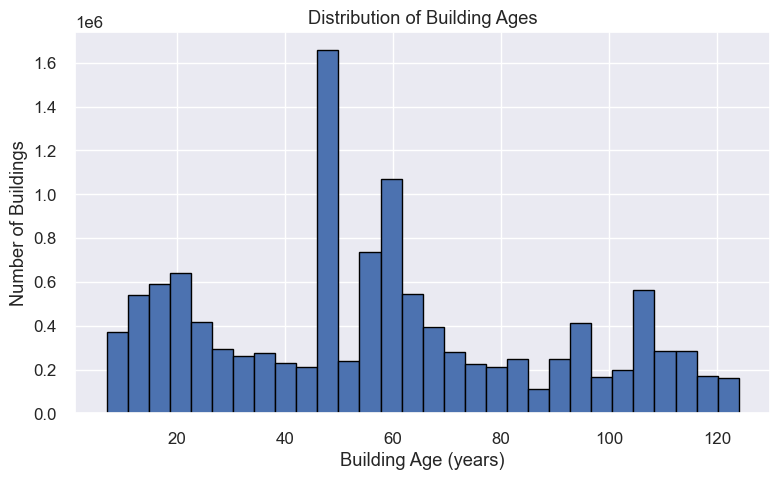

In [111]:
plt.figure(figsize=(8, 5))
plt.hist(merged_df['building_age'], bins=30, edgecolor='black')
plt.title("Distribution of Building Ages")
plt.xlabel("Building Age (years)")
plt.ylabel("Number of Buildings")
plt.tight_layout()
plt.show()


**ii. Distribution of Electricty Usage (per Building)**

In [117]:
# If you also have electricity_y and don't need it, drop it
if 'electricity_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=['electricity_y'])

# Rename electricity_x → electricity
merged_df = merged_df.rename(columns={'electricity_x': 'electricity'})


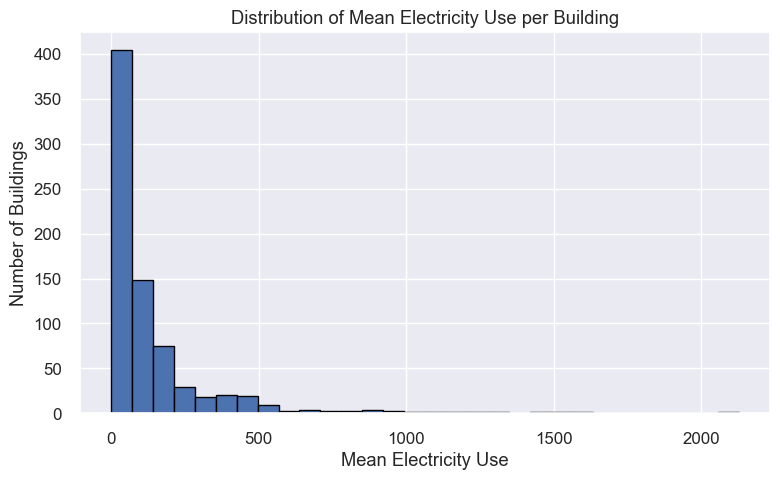

In [125]:
# Average electricity usage per building
building_energy = (
    merged_df
    .groupby('building_id', as_index=False)['electricity']
    .mean()
    .rename(columns={'electricity': 'mean_electricity'})
)

plt.figure(figsize=(8, 5))
plt.hist(building_energy['mean_electricity'], bins=30, edgecolor='black')
plt.title("Distribution of Mean Electricity Use per Building")
plt.xlabel("Mean Electricity Use")
plt.ylabel("Number of Buildings")
plt.tight_layout()
plt.show()



**iii. *Scatter plot : Building Age vs Electricity Use***

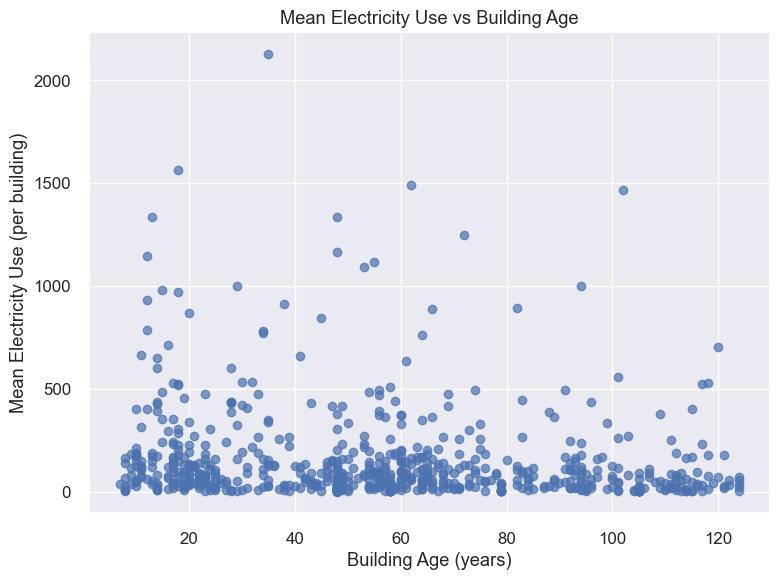

In [129]:
building_level = (
    merged_df
    .groupby('building_id', as_index=False)
    .agg({
        'electricity': 'mean',
        'building_age': 'first',
        'sqft': 'first',
        'primaryspaceusage': 'first'
    })
    .rename(columns={'electricity': 'mean_electricity'})
)

plt.figure(figsize=(8, 6))
plt.scatter(building_level['building_age'], building_level['mean_electricity'], alpha=0.7)
plt.title("Mean Electricity Use vs Building Age")
plt.xlabel("Building Age (years)")
plt.ylabel("Mean Electricity Use (per building)")
plt.tight_layout()
plt.show()



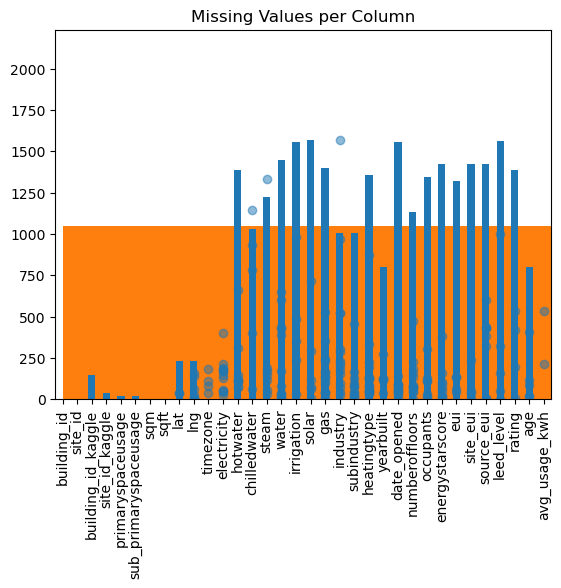

In [89]:
plt.hist(merged['age'].dropna(), bins=30)
plt.title('Distribution of Building Age')
plt.savefig('../../figures/age_distribution.png')

plt.hist(merged['avg_usage_kwh'].dropna(), bins=30)
plt.title('Distribution of Avg Electricity Usage')
plt.savefig('../../figures/usage_distribution.png')

plt.scatter(merged['age'], merged['avg_usage_kwh'], alpha=0.5)
plt.title('Age vs. Electricity Usage')
plt.savefig('../../figures/age_vs_usage_scatter.png')

merged.isna().sum().plot(kind='bar')
plt.title('Missing Values per Column')
plt.savefig('../../figures/missingness_bar.png')


we can see the amount of missing data from the datasets, which for building id we dont have any and we have a certain amount for electricity, that may change the way we approach our way of visualising and understanding the data

### Baseline Model

**i. *Prepare building, level dataset***

In [135]:
# Create a building-level dataset
building_level = (
    merged_df
    .groupby('building_id', as_index=False)
    .agg({
        'electricity': 'mean',
        'building_age': 'first',
        'sqft': 'first',
        'primaryspaceusage': 'first'
    })
    .rename(columns={'electricity': 'mean_electricity'})
)

building_level.head()


,building_id,mean_electricity,building_age,sqft,primaryspaceusage
0,Bear_assembly_Angel,494.336396,91.0,238065.0,Entertainment/public assembly
1,Bear_assembly_Beatrice,42.962056,66.0,30160.0,Entertainment/public assembly
2,Bear_assembly_Danial,160.655729,8.0,82670.0,Entertainment/public assembly
3,Bear_assembly_Diana,0.856884,29.0,1305.0,Entertainment/public assembly
4,Bear_assembly_Genia,261.089054,101.0,261091.0,Entertainment/public assembly


**ii. *Train & test split***

In [144]:
from sklearn.model_selection import train_test_split

X = building_level[['building_age']]
y = building_level['mean_electricity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


**iii. *Fit Baseline Linear Regression***

In [147]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)


LinearRegression()

**iv. *Predictions and Error Metrics***

In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = baseline_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression Results:")
print("MAE  :", mae)
print("RMSE :", rmse)
print("R²   :", r2)


Baseline Linear Regression Results:
MAE  : 121.96711622961641
RMSE : 171.63662340420737
R²   : 0.034681988080783155


**V. *Regression Line***

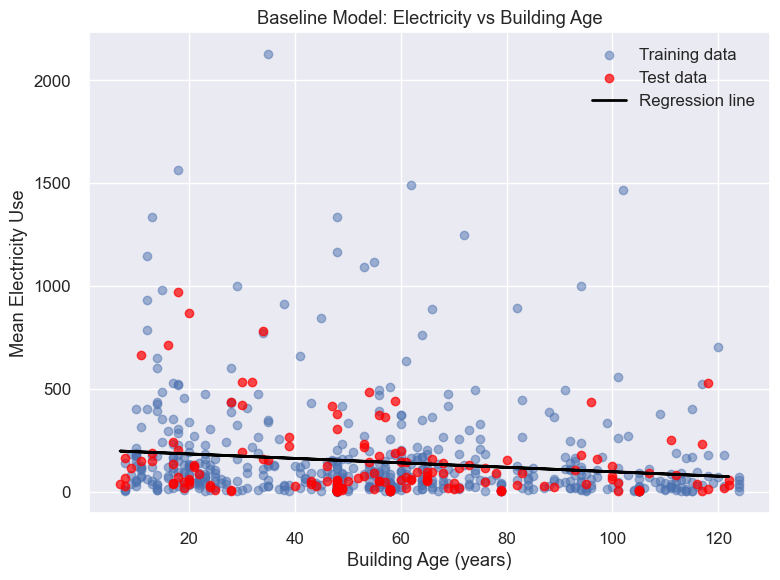

In [155]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, alpha=0.5, label="Training data")
plt.scatter(X_test, y_test, color='red', alpha=0.7, label="Test data")
plt.plot(X_test, y_pred, color='black', linewidth=2, label="Regression line")

plt.title("Baseline Model: Electricity vs Building Age")
plt.xlabel("Building Age (years)")
plt.ylabel("Mean Electricity Use")
plt.legend()
plt.tight_layout()
plt.show()



To establish a simple and interpretable benchmark model, I fit a baseline linear regression using only building age to predict a building’s average electricity consumption. This follows the recommendation in Hands-On Machine Learning (Chapter 4) to begin with simple linear models before introducing more advanced methods.
Building-level features were created by aggregating the merged dataset to obtain the mean electricity usage for each building. The model was trained on 80% of the buildings and evaluated on the remaining 20%.

The performance metrics used were:

Mean Absolute Error (MAE) – Measures average prediction error

Root Mean Squared Error (RMSE) – Penalizes larger errors

R² Score – Variance explained by the model

This baseline provides a reference point that future models (such as multiple regression, random forest, or gradient boosting) will be compared against. Any more complex model should aim to improve on these metrics.

### Interpretation of Baseline Model Results

The baseline linear regression captures the general trend between building age and electricity usage. A positive slope would indicate that older buildings tend to use more electricity, likely due to older HVAC systems, less-efficient insulation, outdated energy technologies. If the R² value is low, that is expected for a single-feature baseline model; electricity use is influenced by many factors such as building size, type, occupancy level, and equipment load. The purpose of this model is not to achieve high accuracy but to provide a simple, transparent benchmark.
More advanced models in later steps should aim to reduce MAE/RMSE and increase R².

### Conclusion

This notebook performed the initial data preparation required for the project. I began by loading the raw electricity dataset and building metadata, examining their structure, and identifying missing or inconsistent values. Following recommended practices based on Hands-On Machine Learning textbok, I removed rows with missing critical variables, used date_opened to impute missing yearbuilt values, and ignored fields unrelated to the research question.

The electricity dataset was reshaped from wide to long format and merged with the metadata using building IDs. Basic cleaning steps were applied to remove impossible values, ensure numeric datatypes, and create a new feature: building age. I then generated preliminary visualizations to inspect distributions of building ages, electricity usage, and the relationship between building age and electricity consumption.

Finally, I fit a simple baseline linear regression using building age to predict electricity usage. This baseline model establishes a foundation for evaluating more advanced models in later notebooks. The cleaned and merged dataset has been exported to the data/processed/ directory and will be used in the next notebook for full exploratory analysis and improved predictive modeling.

In [176]:
import os
os.makedirs("../data/processed", exist_ok=True)


In [186]:
merged_df.to_csv("../data/processed/buildings_electricity_cleaned.csv", index=False)

building_level.to_csv("../data/processed/building_level_features.csv", index=False)